# Import needed modules and useful functions

In [1]:
#-- useful python script to compute the TICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2

#energy
ene: ENERGY

INCLUDE FILE=plumed_descriptors.data

# every 0.2 ps
PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
execute("./run_gromacs.sh",folder=folder)

Completed: cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh unbias_A/
Completed: ./run_gromacs.sh


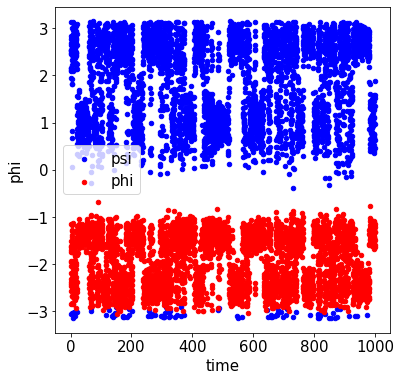

In [4]:
data = load_dataframe(folder+"COLVAR")
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(x="time",y="psi",ax=ax, color="b", label="psi")
data.plot.scatter(x="time",y="phi",ax=ax, color="r", label="phi")
ax.legend()

Text(0, 0.5, '$\\psi$')

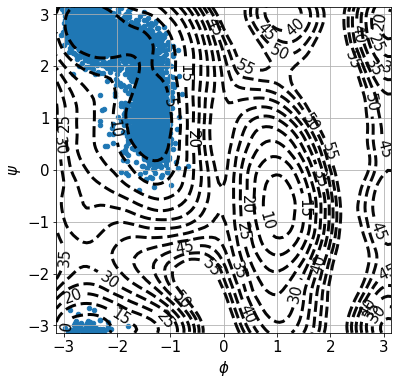

In [5]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

In [6]:
#-- TRAINING PARAMETERS --#
train_parameters = {
              'descriptors': '^d[^a-z]',
              'lag_time':1,
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": False,
              "step": 1 #
              }

In [7]:
'''
data = load_dataframe(folder+"COLVAR")
data = data[::train_parameters["step"]]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

lags = np.linspace(1,10,10)
timescale = np.empty(len(lags))

for i,lag in enumerate(lags):
    # TRAIN
    model.fit(X, t, lag=lag)
    #-- move the model back to cpu for convenience --# 
    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
model.to('cpu')
'''

'\ndata = load_dataframe(folder+"COLVAR")\ndata = data[::train_parameters["step"]]\nX, names, t = data.filter(regex=\'^d[^a-z]\').values, data.filter(regex=\'^d[^a-z]\').columns.values, data[\'time\'].values\n\n# DEVICE\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# MODEL\nmodel = TICA_CV(n_features=X.shape[1])\nmodel.to(device)\n\nlags = np.linspace(1,10,10)\ntimescale = np.empty(len(lags))\n\nfor i,lag in enumerate(lags):\n    # TRAIN\n    model.fit(X, t, lag=lag)\n    #-- move the model back to cpu for convenience --# \n    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]\nmodel.to(\'cpu\')\n'

In [8]:
#plt.plot(lags,timescale)
#print(timescale)
#print(lags)

## DeepTICA Analysis and Export

In [9]:
data = load_dataframe(folder+"COLVAR")
data = data[::train_parameters["step"]]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values

torch.manual_seed(21)
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

# TRAIN
model.fit(X, t, lag=1)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
#print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model.set_params({"feature_names": names})
print( model.plumed_input().splitlines()[:2][8:] )

eigenvalues:  [ 0.77732533  0.59623635  0.5211907   0.34786198  0.3258327   0.29473713
  0.2789904   0.26746732  0.22014141  0.20035452  0.1939419   0.18585885
  0.15864247  0.15680978  0.135462    0.1271299   0.12386656  0.11017587
  0.09503438  0.08277238  0.0764962   0.05548998  0.05193542  0.03885412
  0.02717226  0.01553007  0.00237273 -0.0060566  -0.00853073 -0.01696743
 -0.03432446 -0.04125036 -0.06143828 -0.06694005 -0.09110603 -0.1267195
 -0.14245711 -0.1647958  -0.19291003 -0.1988079  -0.2427014  -0.28070623
 -0.31415108 -0.35047114 -0.41879597]
[]


#### Adding to data the cvs values

In [10]:
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../../../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

In [11]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]
data["cv4"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[3]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]
data_complete["cv3"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[2]
data_complete["cv4"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[3]

<AxesSubplot:ylabel='Frequency'>

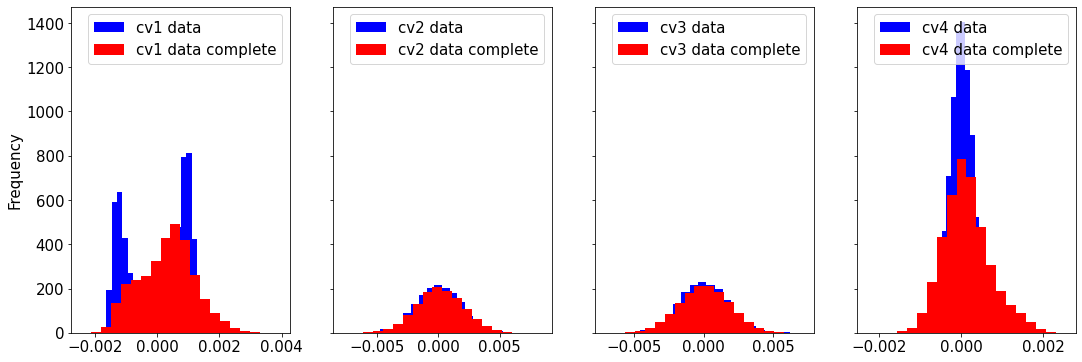

In [12]:
fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b",label="cv1 data")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b",label="cv2 data")
data.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="b",label="cv3 data")
data.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="b",label="cv4 data")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="r",label="cv1 data complete")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r",label="cv2 data complete")
data_complete.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="r",label="cv3 data complete")
data_complete.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="r",label="cv4 data complete")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

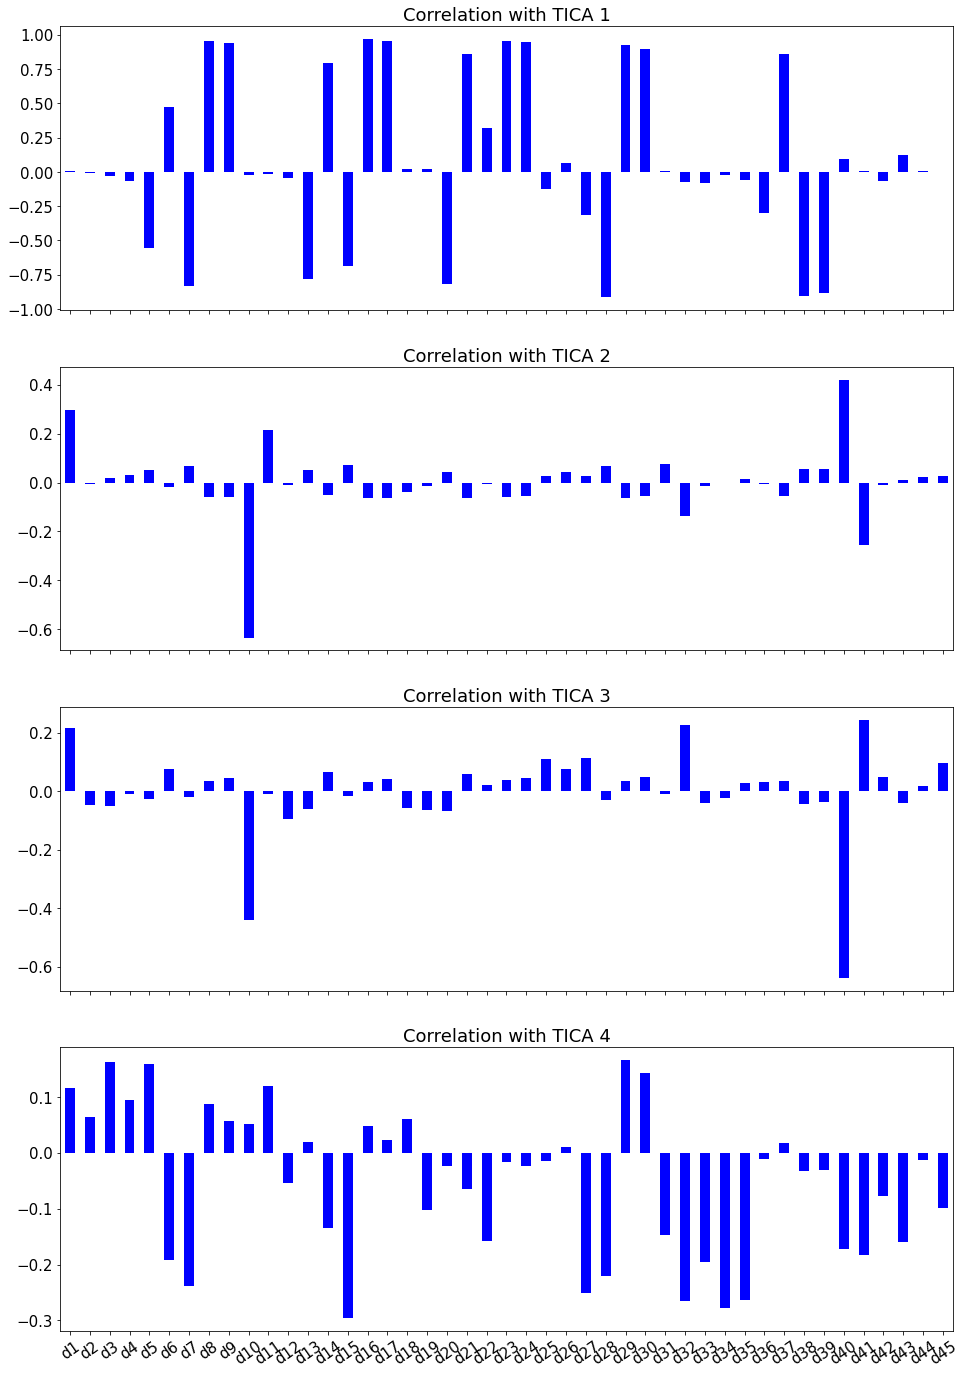

In [13]:
fig,axs = plt.subplots(4,1,figsize=(16,24),sharex=True)
for k,cv in enumerate(["cv1","cv2","cv3","cv4"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(tica|desc)$")
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

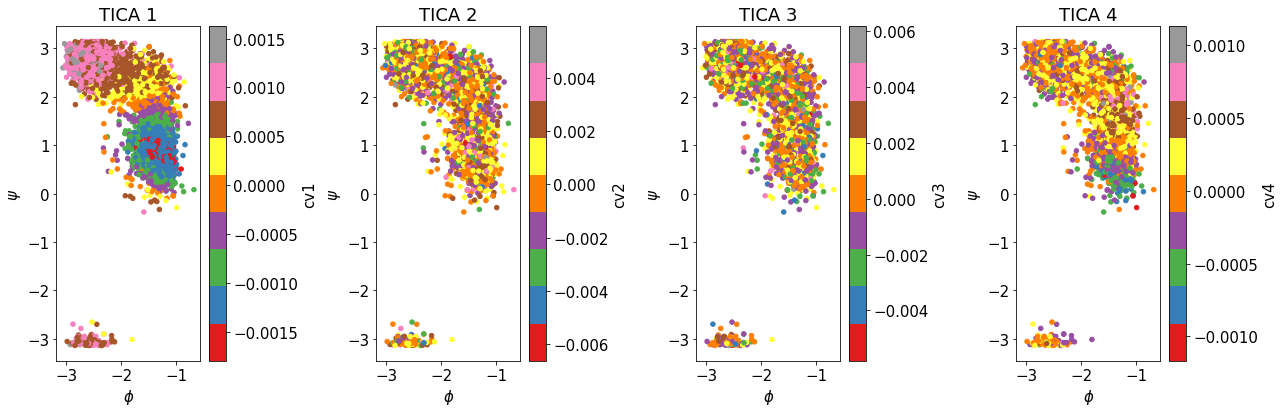

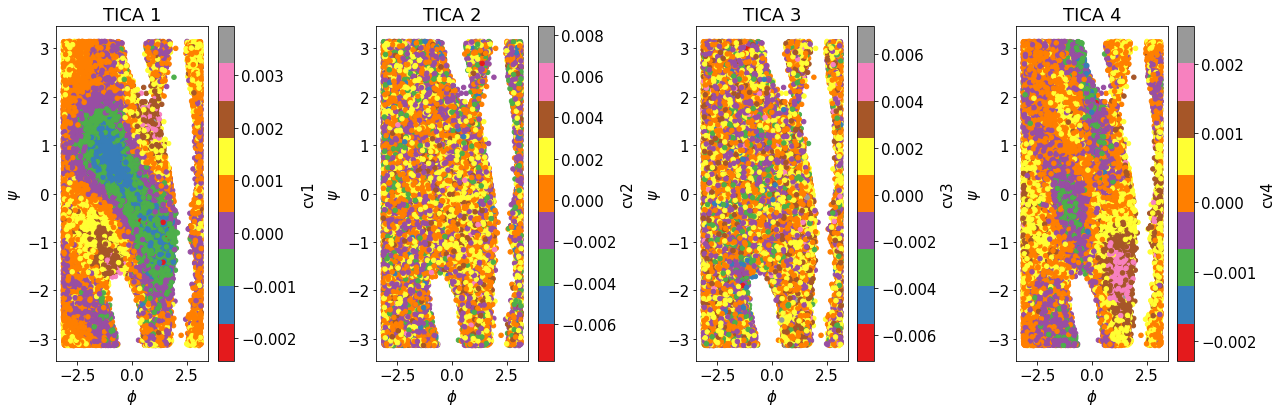

In [14]:
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

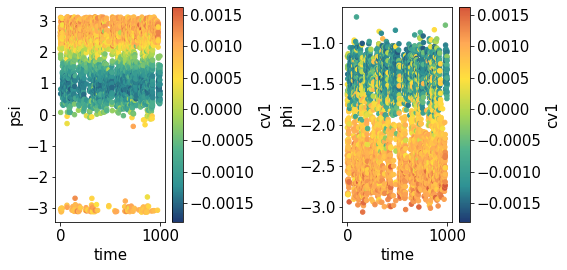

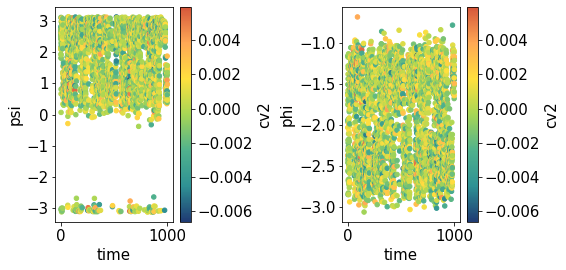

In [15]:
names = ["psi","phi"]
fig,axs = plt.subplots(1,2,figsize=(8,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(8,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [16]:
Boltzmann_product(model,model,X,j=0,k=1)

-1.0348666049265263e-09

# Prepare the next simulation input files
### Plumed

In [17]:
folder = "unbias_A/bias1/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2

#energy
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
tica_cv1_0"""+
model.plumed_input().splitlines()[0][8:]+"""\ntica_cv2_0"""+model.plumed_input().splitlines()[1][8:]
+"""
# bias 
opes: OPES_METAD ARG=tica_cv1_0,tica_cv2_0 TEMP=300 PACE=500 FILE=KERNELS RESTART=NO BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
# every 0.2 ps
PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
execute("cp script/input.* script/plumed_descriptors.data script/positions.data script/run_gromacs.sh "+folder,folder=".")

# restart simulation
execute("sed -i '0,/cpi_state/s/cpi_state.*/cpi_state=true/' run_gromacs.sh",folder=folder, print_result=False)
execute("cp ../alanine.log ../alanine.xtc ../alanine.edr ../state.cpt .",folder=folder, print_result=False)

Completed: cp script/input.* script/plumed_descriptors.data script/positions.data script/run_gromacs.sh unbias_A/bias1/
